# Nucleotide sequence and DNaseI sensitivity are predictive of 3D chromatin architecture

This notebook will contain the code we used to analyze the data and produce the figures shown in the manuscript, as well as helpful commentary about it all. Data is available upon request (send requests to jmschr@cs.washington.edu) but is over 20 gigabytes and so not included in this repository.

The first two figures which show, respectively, the structure of the Rambutan model and the validation at 1kb resolution are not shown. Any mentions of the word contact refers specifically to mid-range contacts defined as between 50kb and 1Mb.

In [2]:
import matplotlib
matplotlib.use('pdf')
%pylab inline

import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

import pandas, numpy

from operator import itemgetter
from scipy.stats import spearmanr

celltypes = 'GM12878', 'K562', 'IMR90', 'NHEK', 'HMEC', 'HUVEC'
colors = ['c', 'm', 'g', 'r', 'b', '#FF6600']

Populating the interactive namespace from numpy and matplotlib


## 1. Rambutan makes cell type specific predictions

After having shown that Rambutan performs well in the 1kb resolution setting when predicting across chromosomes in GM12878, we turned to the task of validating Rambutan's performance when predicting cross cell type. The model is the same model used in the previous task, that is it has been trained on chromosomes 1 through 20 in GM12878 and is now predicting chromosome 21 from all 6 cell types. 

Note that in the manuscript the coloring differs, but the order is still the same. In particular, NHEK is shown in blue in the manuscript and is shown in red here.

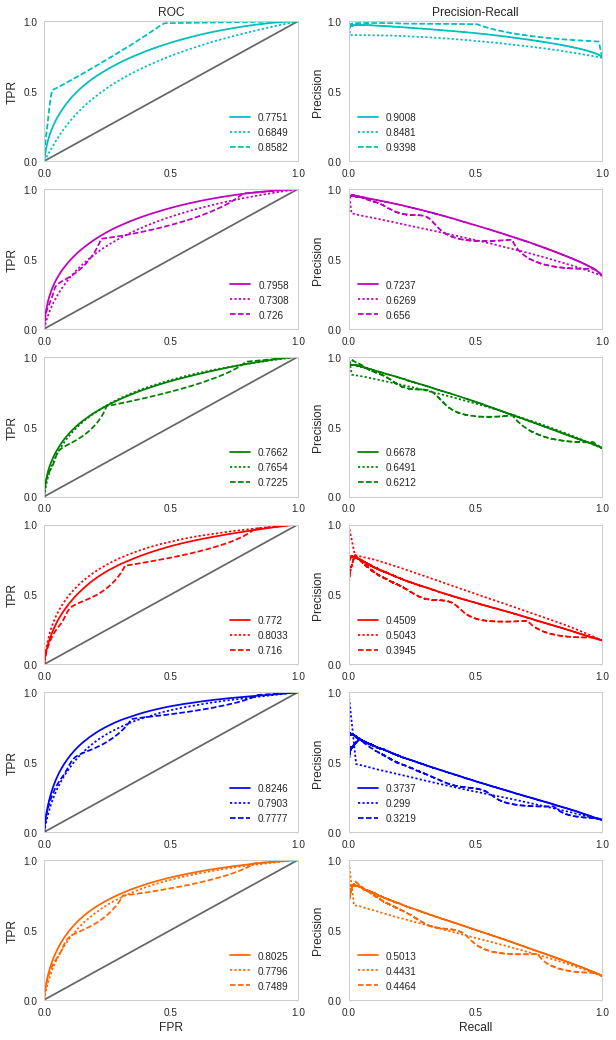

In [3]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

low, high = 10, 201
p, d, idxs = numpy.array([]), numpy.array([]), []

y_pred = numpy.load('contact_maps/chr21.GM12878.y_pred.5000.npy', mmap_mode='r')
p_map = numpy.load('contact_maps/chr21.GM12878.p.5000.1000.npy', mmap_mode='r')

for i in range(low, high):
    # Identify which regions we have predictions for, as some regions are unmappable regions
    # The model will never predict either exactly 0 or exactly 1.
    idx = numpy.diag(y_pred, i) != 0
    idxs.append(idx)
    
    x = -numpy.log(numpy.diag(p_map, i)[idx])
    p = numpy.concatenate([p, x])
    d = numpy.concatenate([d, -numpy.ones_like(x)*i])
    

plt.figure( figsize=(10, 18) )
for i, (c, celltype) in enumerate(zip(colors, celltypes)):
    yp = numpy.load('contact_maps/chr21.{}.y_pred.5000.npy'.format(celltype), mmap_mode='r')
    yt = numpy.load('contact_maps/chr21.{}.y.5000.npy'.format(celltype), mmap_mode='r')
    
    y_true, y_pred = numpy.array([]), numpy.array([])
    for k, idx in zip(range(low, high), idxs):        
        y_true = numpy.concatenate([y_true, numpy.diag(yt, k)[idx]])
        y_pred = numpy.concatenate([y_pred, numpy.diag(yp, k)[idx]])

    plt.subplot(6, 2, (2*i)+1)
    plt.plot([0,1], [0, 1], c='k', alpha=0.6)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    eval_auc = numpy.around(roc_auc_score(y_true, y_pred), 4)
    plt.plot(fpr, tpr, c=c, label=eval_auc)

    fpr, tpr, _ = roc_curve(y_true, d)
    eval_auc = numpy.around(roc_auc_score(y_true, d), 4)
    plt.plot(fpr, tpr, c=c, linestyle=':', label=eval_auc )

    fpr, tpr, _ = roc_curve(y_true, p)
    eval_auc = numpy.around(roc_auc_score(y_true, p), 4)
    plt.plot(fpr, tpr, c=c, linestyle='--', label=eval_auc)

    plt.xticks([0, 0.5, 1], fontsize=10)
    plt.yticks([0, 0.5, 1], fontsize=10)
    plt.ylabel("TPR", fontsize=12)
    plt.legend(loc=4)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(False)

    plt.subplot(6, 2, (2*i)+2)
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    eval_auc = numpy.around(average_precision_score(y_true, y_pred), 4)
    plt.plot(recall, precision, c=c, label=eval_auc)

    precision, recall, _ = precision_recall_curve(y_true, d)
    eval_auc = numpy.around(average_precision_score(y_true, d), 4)
    plt.plot(recall, precision, c=c, linestyle=':', label=eval_auc)

    precision, recall, _ = precision_recall_curve(y_true, p)
    eval_auc = numpy.around(average_precision_score(y_true, p), 4)
    plt.plot(recall, precision, c=c, linestyle='--', label=eval_auc)

    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.xticks([0, 0.5, 1], fontsize=10)
    plt.yticks([0, 0.5, 1], fontsize=10)
    plt.ylabel("Precision", fontsize=12)
    plt.legend(loc=3)
    plt.grid(False)

plt.subplot(6, 2, 1)
plt.title("ROC", fontsize=12)

plt.subplot(6, 2, 2)
plt.title("Precision-Recall", fontsize=12)

plt.subplot(6, 2, 11)
plt.xlabel("FPR", fontsize=12)
plt.ylabel("TPR", fontsize=12)

plt.subplot(6, 2, 12)
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.savefig('ISMB_5kb_validation.pdf')


In [4]:
del precision, recall, fpr, tpr, p, d, x, y_pred, y_true

## 2. Rambutan predictions re-create the insulation score

Insulation score is a metric for the propensity of a locus to engage in local contacts. It is typically calculated by sliding a square down the diagonal of a Hi-C contact map and summing the number of contacts at each locus. It has been used previously for calling TADs. In this section we show that, first, Rambutan predictions can recreate this score by summing Rambutan probabilities instead of number of contacts, and secondly, that insulation score is a useful measurement to recreate due to its strong correlation with other biological phenomena.

First, lets plot the Hi-C derived insulation score against the Rambutan derived Hi-C score. For reference, we will show DNase signal in the background. Since DNase sensitivity is a proxy measurement for how available a region is, it makes sense that it should serve as a superset of the insulation score, where regions can't engage in many contacts if it can't be cut by DNase.

The genomic coordinate begins at 17500kb because regions prior to that are largely unmappable. There is a small island of mappable regions before this, but in order to remove edge effects we ignore those regions and the first few mappable regions on either side of the remainder. The considered region still covers 30 million nucleotides.

In [5]:
r_insulation_score, c_insulation_score, dnases = [], [], []
for celltype in celltypes:
    r_insulation_score.append(numpy.load('insulation/chr21.{}.insulation.rambutan.5000.npy'.format(celltype))[3500:9500])
    c_insulation_score.append(numpy.load('insulation/chr21.{}.insulation.5000.npy'.format(celltype))[3500:9500])
    
    d = numpy.load('dnase/chr21.{}.dnase.npy'.format(celltype))
    dnase = numpy.zeros(9626)
    for i in range(9626):
        dnase[i] = d[i*5000:(i+1)*5000].mean()
    dnase[dnase == 0] = 1
    dnase = numpy.log(dnase) / numpy.log(dnase).std()
    dnases.append(dnase[3500:9500])
    
idx = [(c != 0) & (r != 0) for c, r in zip(c_insulation_score, r_insulation_score)] 
r_insulation_score = [r_insulation_score[i][idx[i]] for i in range(6)]
c_insulation_score = [c_insulation_score[i][idx[i]] for i in range(6)]
dnases = [dnases[i][idx[i]] for i in range(6)]

r_insulation_score = [numpy.log(r_insulation_score[i]) - numpy.log(r_insulation_score[i].mean()) for i in range(6)]
c_insulation_score = [numpy.log(c_insulation_score[i]) - numpy.log(c_insulation_score[i].mean()) for i in range(6)]

zr_insulation_score = [(r_insulation_score[i] - r_insulation_score[i].mean()) / r_insulation_score[i].std() for i in range(6)]
zc_insulation_score = [(c_insulation_score[i] - c_insulation_score[i].mean()) / c_insulation_score[i].std() for i in range(6)]

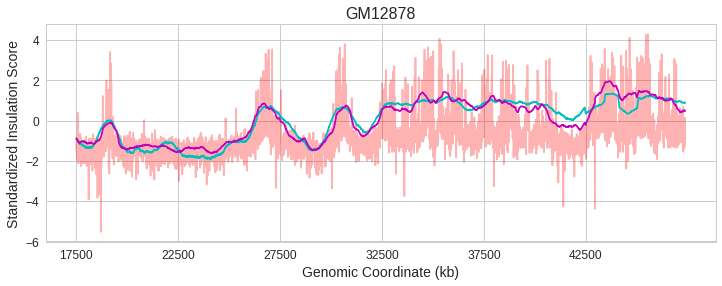

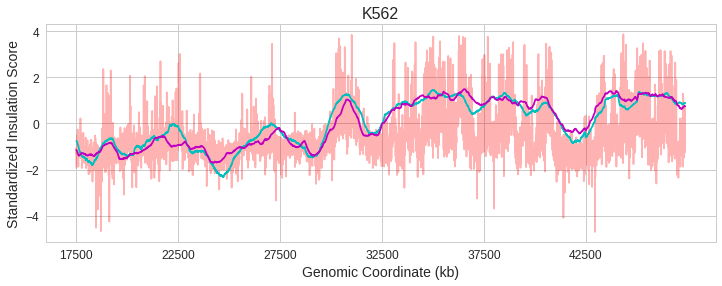

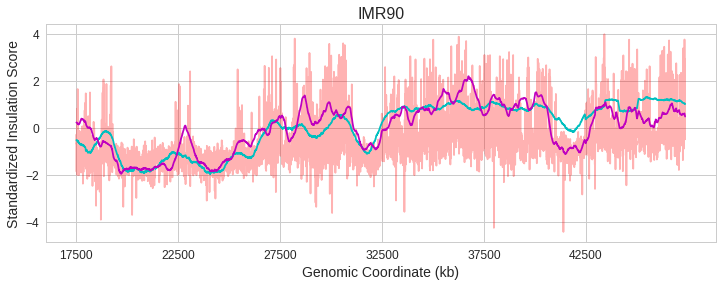

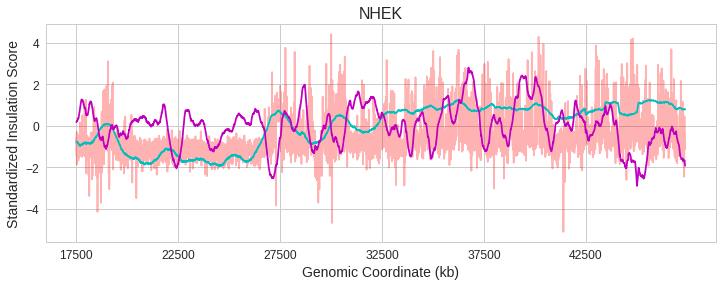

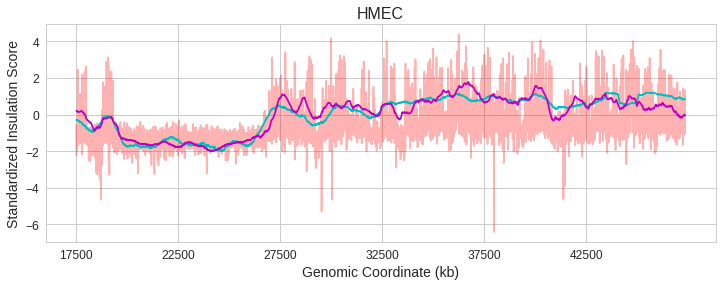

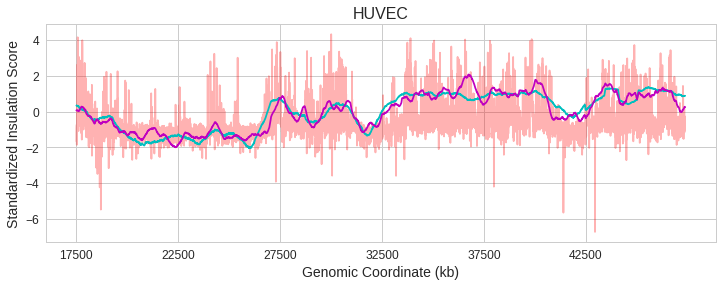

In [6]:
for i, celltype in enumerate(celltypes):
    n = len(zr_insulation_score[i])
    
    plt.figure(figsize=(12, 4))
    plt.title(celltype, fontsize=16)
    plt.plot(dnases[i], color='r', alpha=0.3)
    plt.plot(zr_insulation_score[i], color='c', label="Rambutan")
    plt.plot(zc_insulation_score[i], color='m', label="Hi-C")
    #plt.legend(fontsize=14, loc=2)
    plt.xticks(range(0, n, 1000), range(3500*5, 5*(n+3500), 5000), fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylabel("Standardized Insulation Score", fontsize=14)
    plt.xlabel("Genomic Coordinate (kb)", fontsize=14)
    plt.savefig('figures/{}_insulation_dnase.pdf'.format(celltype))

It looks like there is a connection between the two, with peaks in the traditional insulation score (in purple) peaking at similar places as the Rambutan insulation score. (in cyan). We can get a quantitative measurement for how similar the two are by calculating the Pearson correlation between the two. Since insulation score is calculated by running a square down the diagonal of a contact map, adjacent insulation scores are tightly correlated. To control for this, we compare every independent locus instead of all loci.

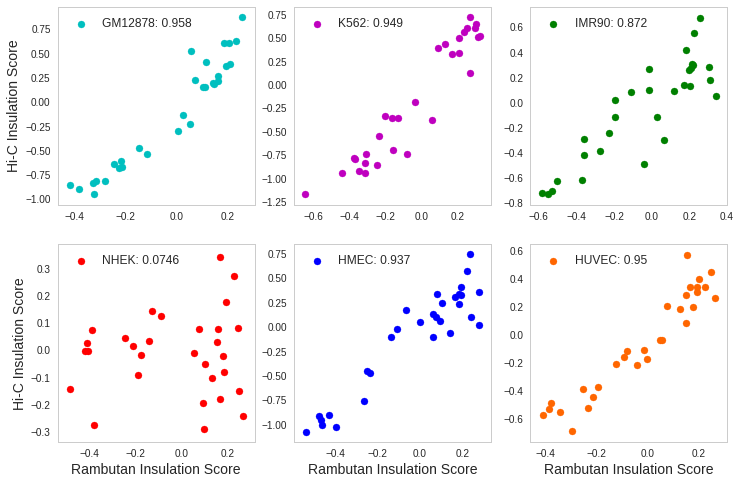

In [7]:
plt.figure(figsize=(12, 8))
plt.title("Rambutan Insulation Score versus Hi-C Insulation Score", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Rambutan Insulation Score", fontsize=14)
plt.ylabel("Insulation Score", fontsize=14)

for i, color, celltype in zip(range(6), colors, celltypes):
    plt.subplot(2, 3, i+1)
    plt.grid(False)
    corr = numpy.corrcoef(r_insulation_score[i][::200], c_insulation_score[i][::200])[0, 1]
    plt.scatter(r_insulation_score[i][::200], c_insulation_score[i][::200], edgecolor=color, color=color, label="{}: {:3.3}".format(celltype, corr))
    plt.legend(fontsize=12, loc=2)

plt.subplot(2, 3, 1)
plt.ylabel("Hi-C Insulation Score", fontsize=14)

plt.subplot(2, 3, 4)
plt.ylabel("Hi-C Insulation Score", fontsize=14)

plt.subplot(2, 3, 4)
plt.xlabel("Rambutan Insulation Score", fontsize=14)
plt.ylabel("Hi-C Insulation Score", fontsize=14)

plt.subplot(2, 3, 5)
plt.xlabel("Rambutan Insulation Score", fontsize=14)

plt.subplot(2, 3, 6)
plt.xlabel("Rambutan Insulation Score", fontsize=14)
plt.savefig('figures/insulation_corr.pdf')

It looks like there is a high correlation across all cell types except for NHEK, where there is almost no correlation. Even in the previous plots we can see that the NHEK derived insulation score acts erratically. We used standard quality control techniques on the NHEK contact map, such as checking the ratio of contacts within a chromosome to those between chromosomes, and found nothing anomalous about it. Given that future validation measurements show that Rambutan's derived score connects with known biology whereas the Hi-C map does not, we believe it is much more likely there was technical error associated with this map rather than interesting biology.

To investigate this further (supplemental figure 4) we plot all insulation scores derived from Hi-C contact maps in one plot, and all insulation scores derived from Rambutan predictions on the other to see if we can spot outliers. In essence, we are now comparing scores on a Hi-C/Rambutan axis rather than on a cell type axis.

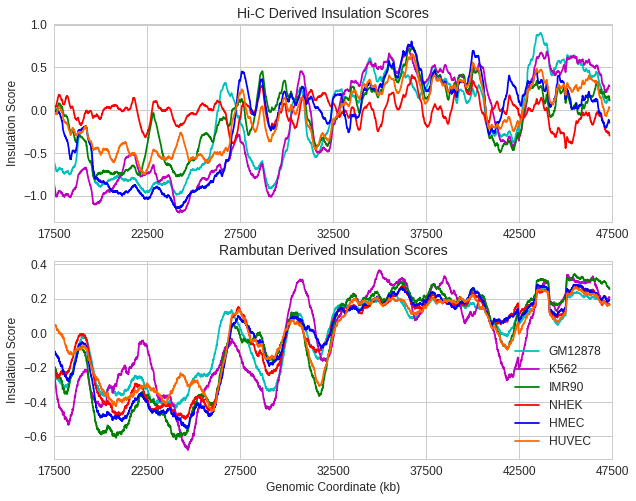

In [8]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
for insulation_score, color, celltype in zip(c_insulation_score, colors, celltypes):
    plt.title("Hi-C Derived Insulation Scores", fontsize=14)
    plt.plot(insulation_score, color=color, label=celltype)
plt.xticks(range(0, 6001, 1000), range(3500*5, 9501*5, 5000), fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("Insulation Score", fontsize=12)
plt.xlim(0, 6000)

plt.subplot(212)
for insulation_score, color, celltype in zip(r_insulation_score, colors, celltypes):
    plt.title("Rambutan Derived Insulation Scores", fontsize=14)
    plt.plot(insulation_score, color=color, label=celltype)
plt.legend(fontsize=12)
plt.xlim(0, 6000)
plt.xticks(range(0, 6001, 1000), range(3500*5, 9501*5, 5000), fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Genomic Coordinate (kb)", fontsize=12)
plt.ylabel("Insulation Score", fontsize=12)
plt.savefig("figures/ISMB_Supp_Insul1.pdf")

NHEK shows up as a clear outlier in the first plot. While other lines typically start off low and end up higher, oscillating throughout, NHEK seems to remain stable oscillating at the same mean. This does not match known biology, wherein there is a depletion of DNase sensitivity at the beginning and more of an enrichment towards the end. 

Lets create a quick heatmap of the pairwise correlations between each cell type for Hi-C and Rambutan derived scores. 

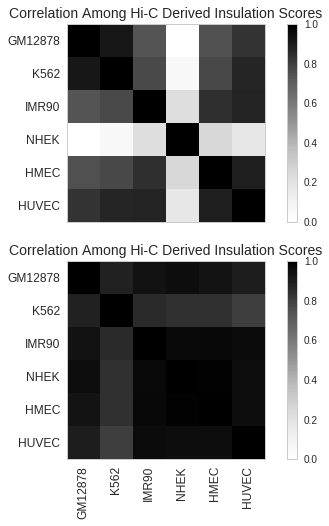

In [9]:
plt.figure(figsize=(8, 8))
plt.subplot(211)
plt.grid(False)
plt.title("Correlation Among Hi-C Derived Insulation Scores", fontsize=14)
plt.imshow(numpy.corrcoef([ins[:5972] for ins in c_insulation_score]), interpolation='nearest', vmin=0, vmax=1)
plt.xticks(range(6), ['']*6)
plt.yticks(range(6), celltypes, fontsize=12)
plt.colorbar()

plt.subplot(212)
plt.grid(False)
plt.title("Correlation Among Hi-C Derived Insulation Scores", fontsize=14)
plt.imshow(numpy.corrcoef([ins[:5972] for ins in r_insulation_score]), interpolation='nearest', vmin=0, vmax=1)
plt.xticks(range(6), celltypes, fontsize=12, rotation=90)
plt.yticks(range(6), celltypes, fontsize=12)
plt.colorbar()
plt.savefig("figures/ISMB_Supp_Insul2.pdf")

It looks like NHEK is a clear outlier in this, not correlating with any other cell type. The Rambutan predictions, on the other hand, are far more correlated with each other as one might expect given that chromatin architecture is largely shared beween cell types. The outlier is K562, which might be explainable because it is the only cancer cell type amongst the rest.

## 3. Insulation score correlates with replication timing

We have now shown that Rambutan can recreate this measurement, insulation score. We now show that this measurement is useful and correlated with known biological processes. The first process is replication timing. We only have replication timing data for 5 of the cell types-- HMEC did not have replication timing data at the time of accession.

In [10]:
celltypes = 'GM12878', 'K562', 'IMR90', 'NHEK', 'HUVEC'
colors = ['c', 'm', 'g', 'r', '#FF6600']

In [11]:
r = [numpy.load('replication/chr21.{}.replication.npy'.format(celltype)) for celltype in celltypes]
replication = [numpy.zeros(9626) for i in range(5)]
rr = [None for i in range(5)]

for i in range(5):
    for j in range(9626):
        replication[i][j] = r[i][j*5000:(j+1)*5000].mean()

    if i == 4:
        rr[i] = replication[i][3500:9500][idx[5]]
    else:
        rr[i] = replication[i][3500:9500][idx[i]]

Let's first plot the same plots as before with insulation score, except instead of comparing to DNase signal lets compare to replication timing measurements. In this case, replication timing is shown in blue.

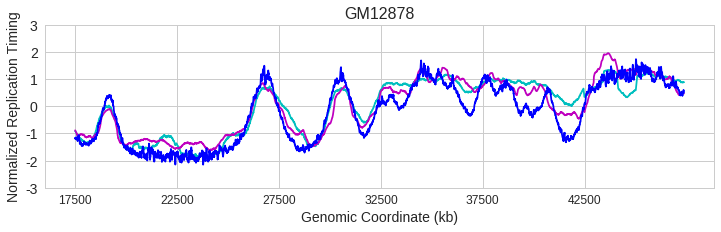

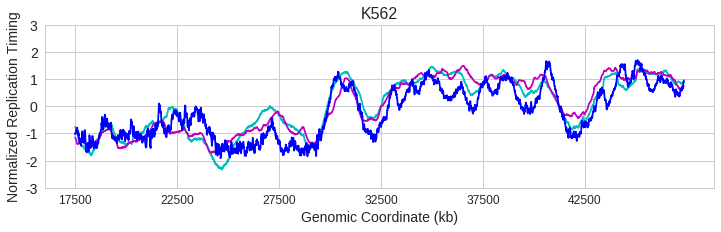

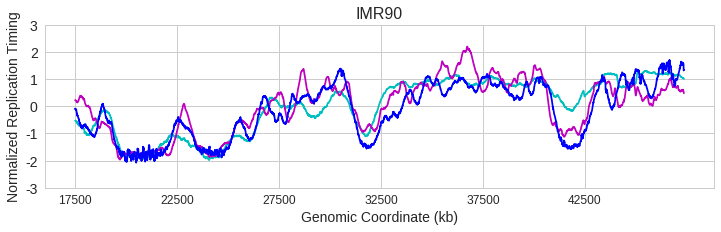

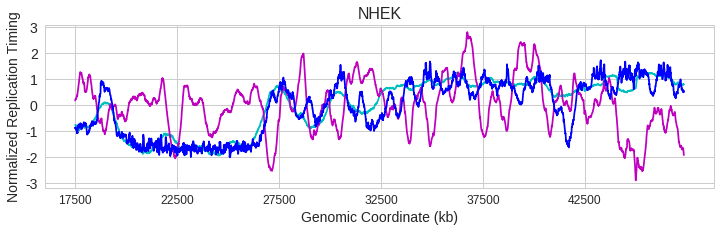

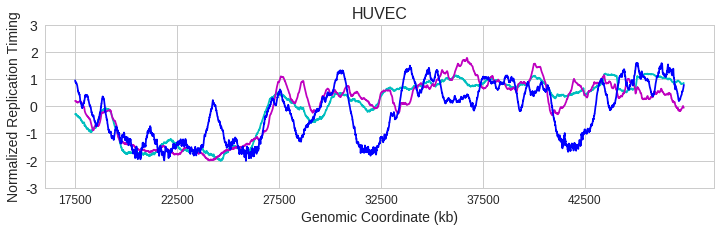

In [12]:
for i, celltype in zip(range(5), celltypes):
    plt.figure(figsize=(12, 3))
    plt.title(celltype, fontsize=16)
    plt.plot(zr_insulation_score[i], color='c', label="Rambutan")
    plt.plot(zc_insulation_score[i], color='m', label="Hi-C")
    plt.plot(rr[i] , color='b', label="Replication Timing")
    #plt.legend(fontsize=14, loc=2)
    plt.xticks(range(0, n, 1000), range(3500*5, 5*(n+3500), 5000), fontsize=12)
    plt.yticks(range(-3, 4), range(-3, 4), fontsize=14)
    plt.ylabel("Normalized Replication Timing", fontsize=14)
    plt.xlabel("Genomic Coordinate (kb)", fontsize=14)
    plt.savefig('figures/{}_replication_timing.pdf'.format(celltype))

It appears that insulation score matches replication timing fairly well across cell types, except for Hi-C derived insulation score in NHEK.

We then calculated the correlations between replication timing signal and insulation score as before.

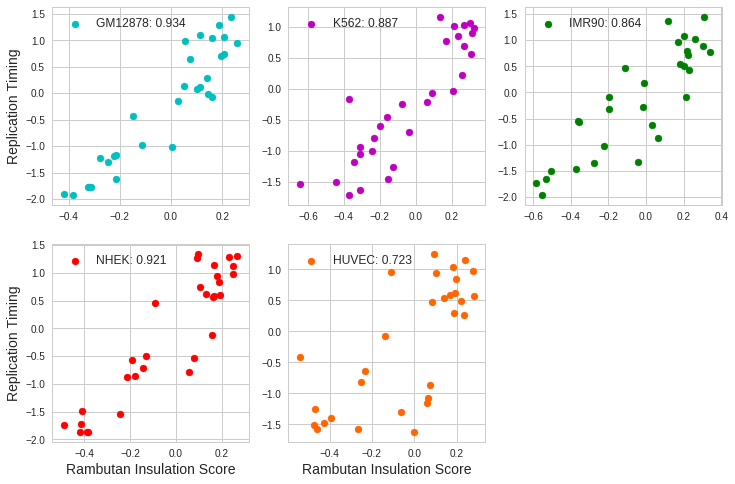

In [13]:
plt.figure(figsize=(12, 8))
for i, color, celltype in zip(range(5), colors, celltypes):
    plt.subplot(2, 3, i+1)
    plt.grid(True)
    corr = numpy.corrcoef(r_insulation_score[i][::200], rr[i][::200])[0, 1]
    plt.scatter(r_insulation_score[i][::200], rr[i][::200], edgecolor=color, color=color, label="{}: {:3.3}".format(celltype, corr))
    plt.legend(fontsize=12, loc=2)

plt.subplot(2, 3, 1)
plt.ylabel("Replication Timing", fontsize=14)

plt.subplot(2, 3, 4)
plt.ylabel("Replication Timing", fontsize=14)

plt.subplot(2, 3, 4)
plt.xlabel("Rambutan Insulation Score", fontsize=14)
plt.ylabel("Replication Timing", fontsize=14)

plt.subplot(2, 3, 5)
plt.xlabel("Rambutan Insulation Score", fontsize=14)
plt.savefig('replication_corr.pdf')

Across all cell types it appears that replication timing signal is connected to Rambutan derived insulation score. This is a good first connection indicating that our predictions are reasonable.

## 4. insulation score is indicative of histone modification function

We next look to connect insulation score to histone modifications, an independent measurement to replication timing. We downloaded ChIP-seq data for four histone modifications, of which three (H3K36me3, H3K27me3, and H4K20me1) are associated with enhanced gene expression and one (H3K9me3) is a known gene repressor. We would expect that insulation score should positively correlate with modifications associated with enhanced gene expression and should negatively correlate with the repressor. 

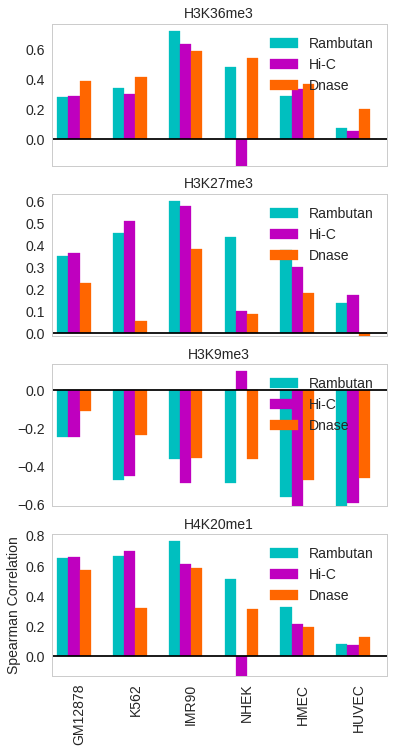

In [14]:
celltypes = 'GM12878', 'K562', 'IMR90', 'NHEK', 'HMEC', 'HUVEC'
colors = ['c', 'm', 'g', 'r', 'b', '#FF6600']
histone_names = ['H3K36me3', 'H3K27me3', 'H3K9me3', 'H4K20me1']

plt.figure(figsize=(6, 12))

for ix, his in enumerate(histone_names):
    rvals, ivals, dvals = [], [], []
    
    for i, celltype in enumerate(celltypes):
        rambutan = numpy.load("insulation/chr21.{}.insulation.rambutan.5000.npy".format(celltype))
        insulation = numpy.load("insulation/chr21.{}.insulation.5000.npy".format(celltype))
        
        h = numpy.load('histone/chr21.{}.{}.npy'.format(celltype, his))
        histone = numpy.zeros(rambutan.shape[0])
        for j in range(rambutan.shape[0]):
            histone[j] = h[j*5000:(j+1)*5000].mean() 
        
        rambutan = rambutan[3500:9500][idx[i]]
        insulation = insulation[3500:9500][idx[i]]
        histone = histone[3500:9500][idx[i]]
        
        rvals.append(spearmanr(rambutan, histone)[0])
        ivals.append(spearmanr(insulation, histone)[0])
        dvals.append(spearmanr(dnases[i], histone)[0])
    
    plt.subplot(4, 1, ix+1)
    plt.title(his, fontsize=14)
    plt.xticks(range(6), ['']*6)
    plt.bar(numpy.arange(6)-0.3, rvals, width=0.2, facecolor='c', edgecolor='c', label="Rambutan")
    plt.bar(numpy.arange(6)-0.1, ivals, width=0.2, facecolor='m', edgecolor='m', label="Hi-C")
    plt.bar(numpy.arange(6)+0.1, dvals, width=0.2, facecolor='#FF6600', edgecolor='#FF6600', label="Dnase")
    plt.plot([-0.5, 5.5], [0, 0], color='k')
    plt.legend(fontsize=14, loc=1)
    plt.grid(False)
    plt.yticks(fontsize=14)
    plt.xlim(-0.5, 5.5)

plt.subplot(4, 1, 4)
plt.ylabel("Spearman Correlation", fontsize=14)
plt.xticks(range(6), celltypes, rotation=90, fontsize=14)
plt.savefig('figures/histones.pdf')

It appears that the hypothesis is correct, insualtion score correlates based on a modifications effect on gene expression. This makes sense, because we would expect that genes which are highly expressed would be in contact with enhancers and other genomic elements, whereas genes which are not being expressed would be more tightly bound and not interact with the remainder of the genome.

We plot DNase's correlation for comparison because the Rambutan model takes DNase sensitivity as an input, and we don't want it to simply be outputting a scaled version of DNase as an output. We see this is not the case, because the two insulation scores seem to match each other far better in a variety of settings than either of them do with DNase signal. This indicates that genomic structure's correlation with histone marks goes further than just how available a region is to the outside world.

In [15]:
del dnases, c_insulation_score, r_insulation_score, zc_insulation_score, zr_insulation_score

## 5. Synchronously replicating regions are linked by high confidence Rambutan calls

Now lets take a section out of the Fit-Hi-C paper where they looked at pairs of regions and determined that if they were in contact with each other they were likely to share the same replication timings. In this case I've ranked Rambutan predictions by the confidence and calculate the correlation of the top $i$ and bottom $i$ for certain sizes. It looks like the top predictions have high correlation, but the bottom predictions have a far lower correlation. Much like in the paper, this shows that Rambutan is bringing together regions with similar replication timing. 

In [16]:
celltypes = 'GM12878', 'K562', 'IMR90', 'NHEK', 'HUVEC'
preds, truths = [], []
for k, celltype in enumerate(celltypes):
    y = numpy.load('contact_maps/chr21.{}.p.5000.npy'.format(celltype))
    y_pred = numpy.load('contact_maps/chr21.{}.y_pred.5000.npy'.format(celltype))

    pred = []
    truth = []
    for i in range(9626):
        for j in range(i, 9626):
            if y_pred[i, j] != 0:
                pred.append([j-i, y_pred[i, j], replication[k][i], replication[k][j]])
                truth.append([j-i, y[i, j], replication[k][i], replication[k][j]])

    preds.append(numpy.array(pred))
    truths.append(numpy.array(truth))

In [17]:
n = 1000

fithic_high, fithic_low = [], []
rambutan_high, rambutan_low = [], []

for y, yp in zip(truths, preds):
    fh, fl, rh, rl = [], [], [], []
    for i in range(10, 201):
        x = yp[yp[:,0] == i]
        idxs = x[:,1].argsort()
        rl.append(numpy.abs(x[idxs[:-n], 3] - x[idxs[:-n], 2]).mean())
        rh.append(numpy.abs(x[idxs[-n:], 3] - x[idxs[-n:], 2]).mean())

        x = y[y[:,0] == i]
        idxs = x[:,1].argsort()
        fh.append(numpy.abs(x[idxs[:n], 3] - x[idxs[:n], 2]).mean())
        fl.append(numpy.abs(x[idxs[n:], 3] - x[idxs[n:], 2]).mean())
    
    fithic_high.append(fh)
    fithic_low.append(fl)
    rambutan_high.append(rh)
    rambutan_low.append(rl)

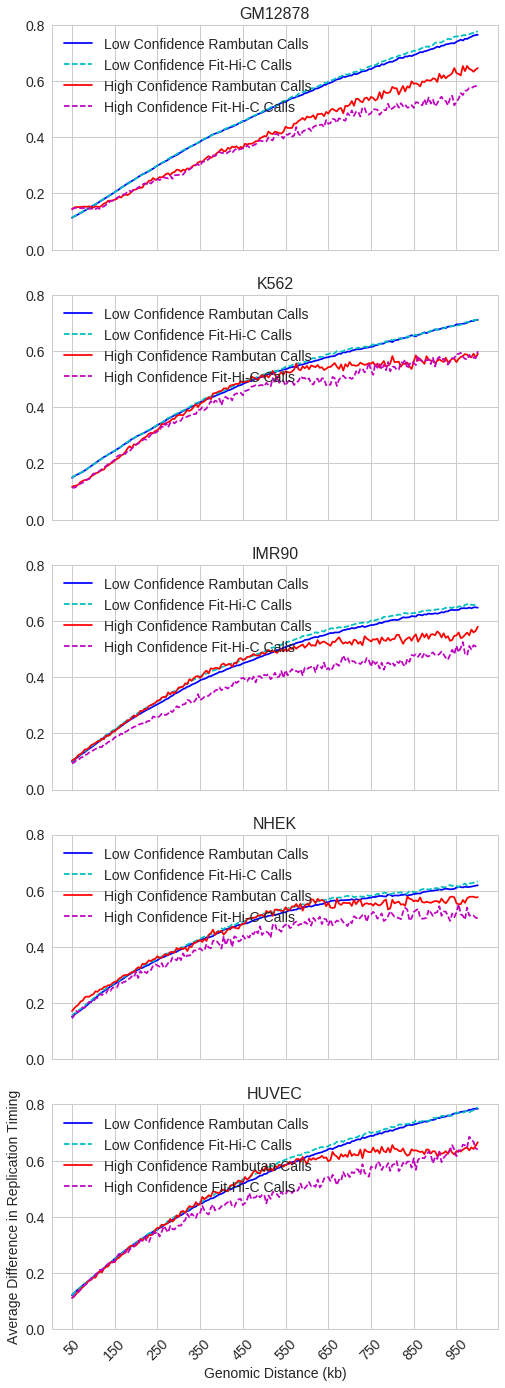

In [18]:
plt.figure(figsize=(6, 14))
plt.figure(figsize=(8, 24))
for i, celltype in enumerate(celltypes):
    plt.subplot(5, 1, i+1)
    plt.title(celltype, fontsize=16)
    plt.yticks(numpy.arange(0.0, 1, 0.2), numpy.arange(0.0, 1, 0.2), fontsize=14)
    plt.xticks(range(0, 191, 20), ['', '', '', '', ''])
    plt.ylim(0, 0.8)
    
    plt.plot(rambutan_low[i],  'b'  , label="Low Confidence Rambutan Calls")
    plt.plot(fithic_low[i],    'c--', label="Low Confidence Fit-Hi-C Calls")
    plt.plot(rambutan_high[i], 'r'  , label="High Confidence Rambutan Calls")
    plt.plot(fithic_high[i],   'm--', label="High Confidence Fit-Hi-C Calls")
    plt.legend(loc=2, fontsize=14)

plt.xlabel("Genomic Distance (kb)", fontsize=14)
plt.ylabel("Average Difference in Replication Timing", fontsize=14)
plt.xticks(range(0, 191, 20), numpy.arange(10, 201, 20)*5, fontsize=14, rotation=45)
plt.savefig('figures/replication_diff.pdf')

We can see that across cell types replciation timing is shared more heavily by high confidence contacts than by low confidence contacts. This suggests that contacts are in fact linking together regions which are synchronously replicating. While Rambutan is not able to replicate this divergence to its full magnitude, it is still strongly present. Rambutan being able to reproduce this result is strongly indicative that the contacts are correct.

In [19]:
del fithic_high, fithic_low, fh, fl, rambutan_high, rambutan_low, rh, rl, x

## 5. Gene regulatory elements in the genome are enriched for predicted contacts

Next, we wanted to show that Rambutan predictions show expected enrichments in functional elements. In particular, it has previously been shown that gene regulatory elements like promoters and enhancers are enriched for contacts (like amongst themselves) whereas quiescent regions are depleted for contacts. This is consistent with our view of chromatin architecture, where most mid range contacts serve some functional purpose.

To quantify this, we first calculate the number of contacts which each 5kb locus engages in. This is either the sum of the number of Hi-C contacts or the sum of the probabilities predicted by Rambutan. Functional annotations are then assigned across the chromosome according to Segway, a semi-automated genome annotater. Loci which fall completely within a functional annotation assign all of their contacts to that annotation. Since Segway operates on the scale of single nucleotides it is far higher resolution than the Hi-C predictions. If a locus gets divided into multiple annotations, then it assigns its contacts to each annotation in proportion to the amount of the locus covered by that annotation. We then report the log enrichment of contacts for each annotation compared to a baseline of random distribution of contacts.

In [20]:
celltypes = 'GM12878', 'K562', 'IMR90', 'NHEK', 'HMEC', 'HUVEC'
colors = ['c', 'm', 'g', 'r', 'b', '#FF6600']

In [21]:
m = 5000.
rambutans, contacts, label_list = [], [], []
for celltype in celltypes:
    data = pandas.read_csv("segway/SEGWAY_{}.bed".format(celltype), sep="\t", header=None)
    data = data[data[0] == 'chr21'][[1, 2, 3]]

    y = numpy.load('segway/chr21.{}.y_sum.5000.npy'.format(celltype))
    r = numpy.load('segway/chr21.{}.y_pred_sum.5000.npy'.format(celltype))
    
    labels = sorted(list(data[3].unique()))
    n = len(labels)
    
    mapping = {label: i for i, label in enumerate(labels)}
    rambutan = numpy.zeros((9626, n))
    contact = numpy.zeros((9626, n))
    random = numpy.zeros((9626, n))

    for _, (start, end, kind) in data.iterrows():
        k = mapping[kind]
        i, j = int(start // m), int(end // m)
        for l in range(i, j+1):
            rambutan[l, k] += r[l] if end-start > m else r[l] * (end-start) / m
            contact[l, k] += y[l] if end-start > m else y[l] * (end-start) / m
            random[l, k] += (end-start) / m


    rambutan = rambutan.sum(axis=0) / rambutan.sum()
    contact = contact.sum(axis=0) / contact.sum()
    random = random.sum(axis=0) / random.sum()
    rambutan = numpy.log(rambutan / random)
    contact = numpy.log(contact / random)
    rambutan, contact, random, labels = (numpy.array(list(x)) for x in zip(*sorted(zip(rambutan, contact, random, labels),key=itemgetter(1))))
    
    rambutans.append(rambutan)
    contacts.append(contact)
    label_list.append(labels)

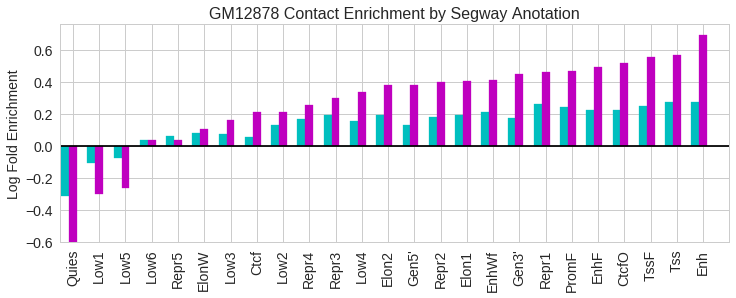

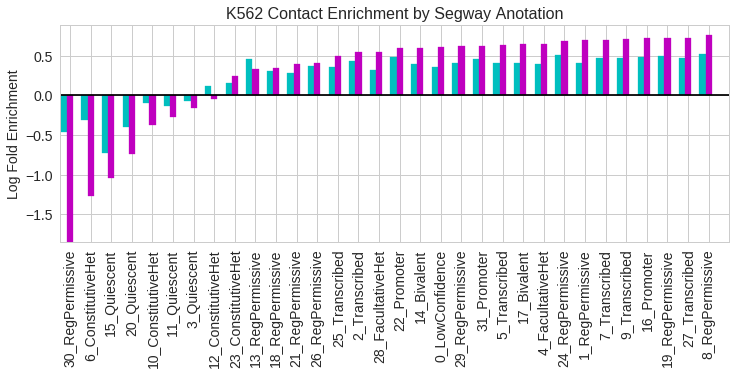

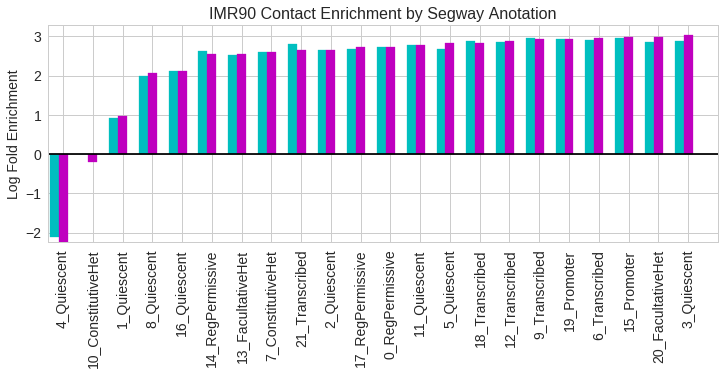

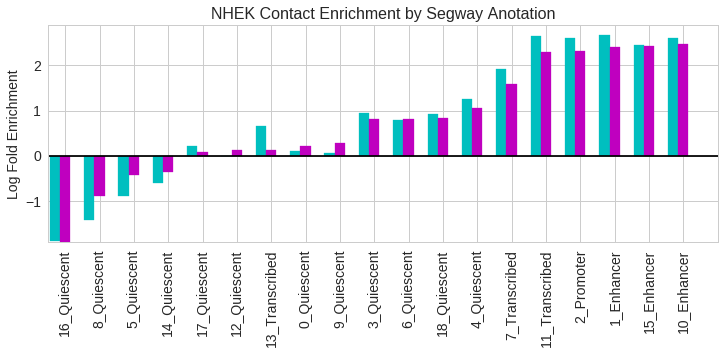

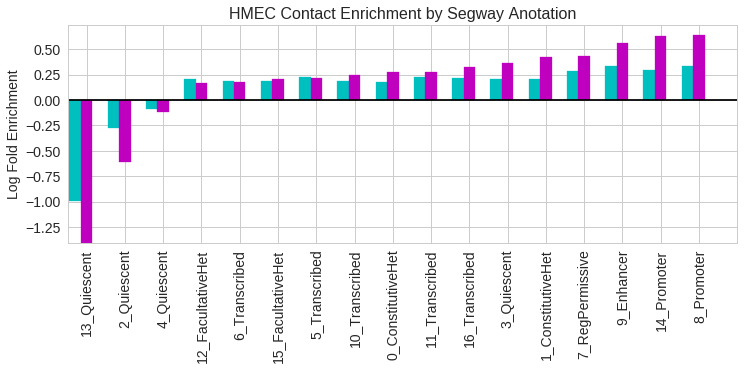

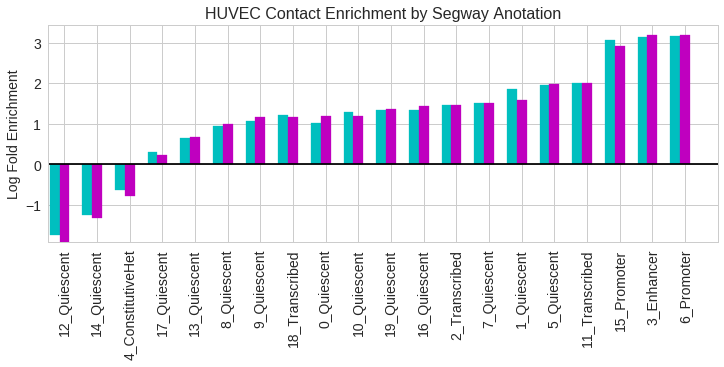

In [22]:
for celltype, rambutan, contact, labels in zip(celltypes, rambutans, contacts, label_list):
    n = len(rambutan)
    plt.figure(figsize=(12, 4))
    plt.title("{} Contact Enrichment by Segway Anotation".format(celltype), fontsize=16)
    plt.plot([-0.5, n], [0, 0], color='k')
    plt.bar(numpy.arange(n)-0.3, rambutan, width=0.3, facecolor='c', edgecolor='c', label="Rambutan")
    plt.bar(numpy.arange(n), contact, width=0.3, facecolor='m', edgecolor='m', label="Hi-C")
    plt.xticks(range(n), labels, rotation=90, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(-0.5, n)
    plt.ylabel("Log Fold Enrichment", fontsize=14)
    #plt.legend(fontsize=16, loc=2)
    plt.grid(True)
    plt.savefig('figures/{}_segway.pdf'.format(celltype))

Looks like we're getting good agreement between the predictions and the actual results. This is another good sign that Rambutan's predictions don't just perform well on traditional accuracy metrics, but are also consistent with biological trends. Let's make a scatterplot of the results like we did with the insulation score results.

In [29]:
plt.figure(figsize=(18, 12))
for i, color, celltype in zip(range(6), colors, celltypes):
    plt.subplot(2, 3, i+1)
    corr = numpy.corrcoef(rambutans[i], contacts[i])[0, 1]
    plt.scatter(rambutans[i], contacts[i], color=color, s=50, linewidth=0, label="{}: {:3.3}".format(celltype, corr))
    plt.legend(fontsize=14, loc=2)

plt.subplot(2, 3, 1)
plt.ylabel("Hi-C Insulation Score", fontsize=14)

plt.subplot(2, 3, 4)
plt.ylabel("Hi-C Insulation Score", fontsize=14)

plt.subplot(2, 3, 4)
plt.xlabel("Rambutan Insulation Score", fontsize=14)
plt.ylabel("Hi-C Insulation Score", fontsize=14)

plt.subplot(2, 3, 5)
plt.xlabel("Rambutan Insulation Score", fontsize=14)

plt.subplot(2, 3, 6)
plt.xlabel("Rambutan Insulation Score", fontsize=14)
plt.savefig('figures/segway_corr.pdf')

TypeError: zip argument #2 must support iteration

Looks like there is extremely high agreement between Hi-C experiments and Rambutan predictions in terms of enrichment by functional loci across cell types. While this is a very high level comparison, it is good that the measurements are very similar. 

## 7. Roadmap Imputations

As of now, we've shown using traditional metrics that Rambutan is accurate, and with three independent lines of reasoning with respect to trends with biological data that the predictions are meaningful. We now want to apply this model to cell types for which no Hi-C data has ever been collected and probe their chromatin architecture. We acquired data on 53 human cell types from the Roadmap Epigenomics Consortium for which DNaseI data was readily available and used Rambutan to predict contact maps for chromosome 21.

Let's first take a look at what these insulation scores look like.

In [25]:
%pylab inline
import pandas; pandas.set_option('display.max_colwidth', 50); pandas.set_option('display.width', 120)
import seaborn; seaborn.set_style('whitegrid'); seaborn.set(font="monospace")

namemap = numpy.loadtxt('RoadmapNames.txt', delimiter=' ', dtype=str)
d = {int(e[1:]) : (name, type) for e, name, type in namemap}

Populating the interactive namespace from numpy and matplotlib


/home/jmschr/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


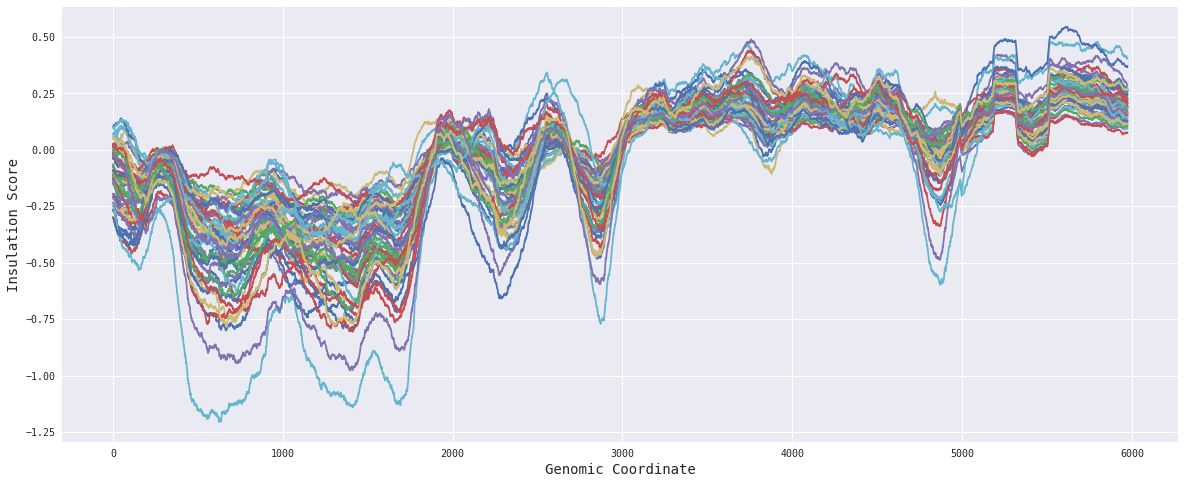

In [26]:
plt.figure(figsize=(20, 8))
plt.ylabel("Insulation Score", fontsize=14)
plt.xlabel("Genomic Coordinate", fontsize=14)
insulation_scores = []
celltypes = []
names = []
types = []

for i in range(129):
    celltype = 'E{}'.format(str(i).zfill(3))
    
    try:
        data = numpy.load('roadmap/chr21.{}.insulation.rambutan.5000.npy'.format(celltype))
        data = data[3500:9500]
        data = data[data != 0]
        data = numpy.log(data) - numpy.log(data.mean())
        celltypes.append(i)
        names.append(d[i][0])
        types.append(d[i][1])
        insulation_scores.append(data)
        plt.plot(data)
    except:
        pass

types = numpy.array(types)
plt.show()
n = len(celltypes)

It would appear that some high level trends are preserved across cell types, such as shared peaks and dips, but the magnitude of these areas differes vastly. In particular, the bottom cyan line seems to stand out as being an extreme in terms of insulation score. In general though, it is good that these high level trends are preserved, because chromatin architecture is largely preserved across cell types.

Next we calculate the correlation between each of the insulation scores and plot a heirarchical clustering of these values to attempt to identify outliers.

/home/jmschr/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/jmschr/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if xticklabels == []:


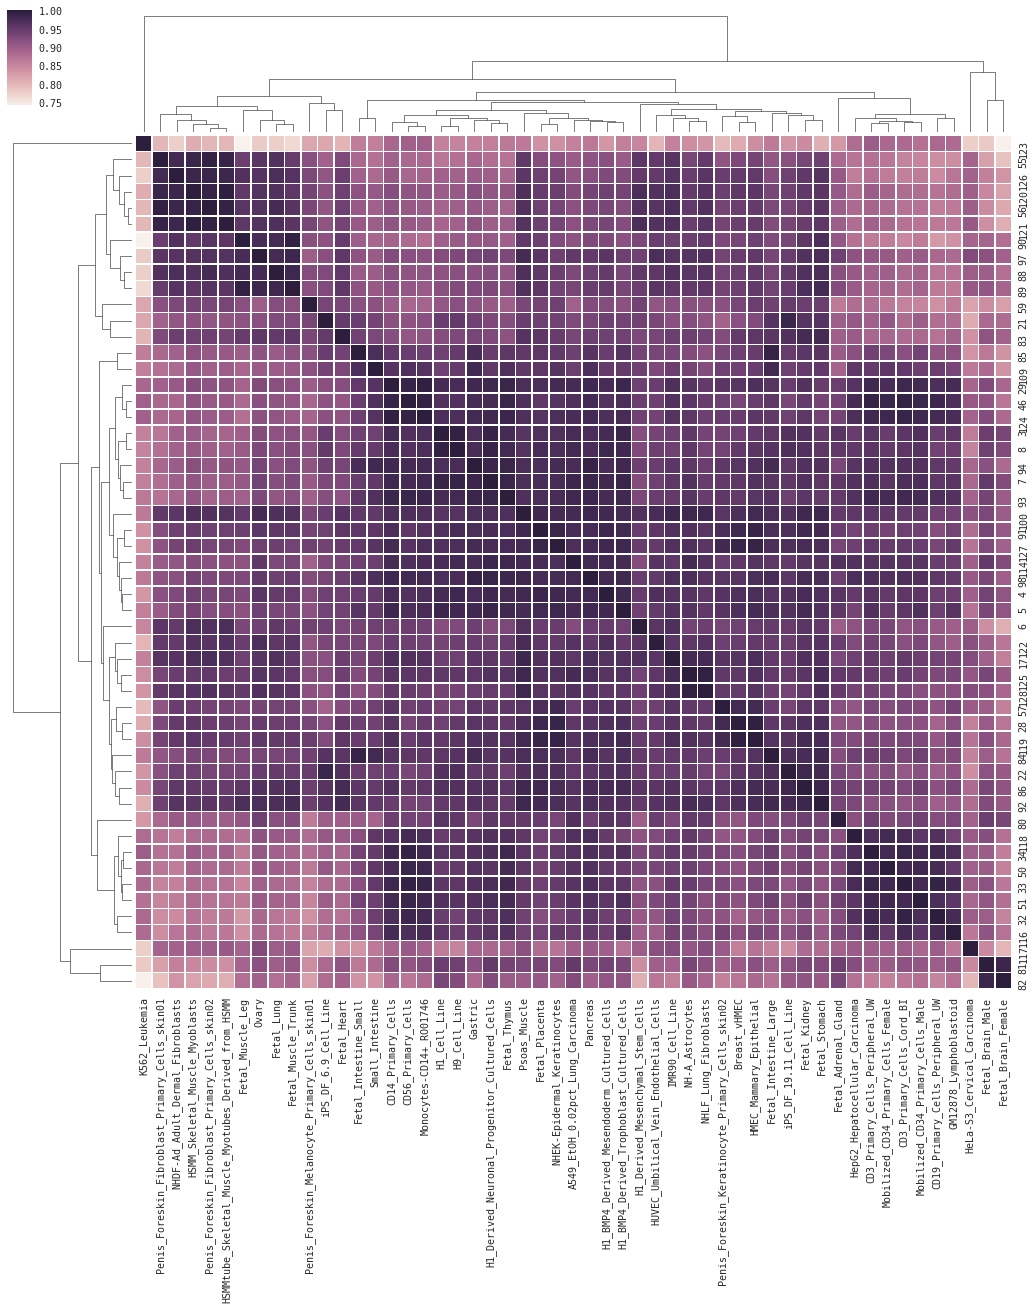

In [27]:
corr = numpy.corrcoef(insulation_scores)
seaborn.clustermap(corr, linewidths=.5, figsize=(18, 18), xticklabels=names, yticklabels=celltypes)

It would appear that K562 leukemia is one least like the others. In addition, the fetal brain cells and cervical carcinoma appear different than the rest. Some groupings appear vaguely in this matrix. To sharpen these clusters, we use the algorithm tSNE to visualize these clusters in two dimensions. The input to tSNE is a distance matrix made up of 1 minus the correlations, so that highly correlated cell types have a small distance between them. 

In [ ]:
from sklearn.manifold import TSNE
labels = set(label for label in types)

clf = TSNE(metric='precomputed', method='exact', perplexity=1, learning_rate=10, n_iter=100000)
embedding = clf.fit_transform(1-corr)

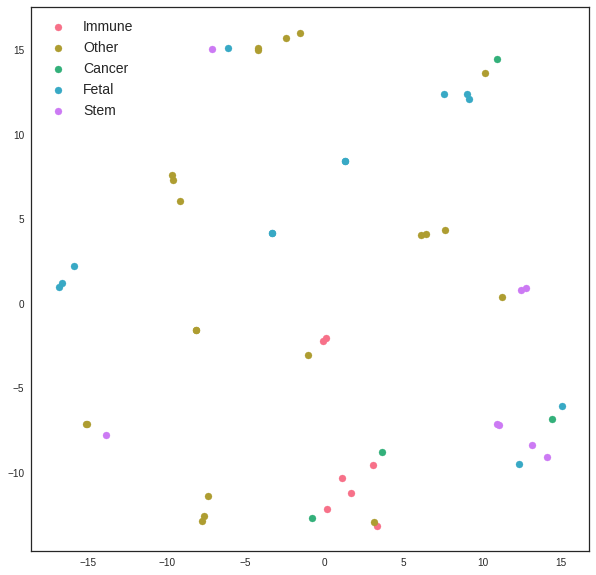

In [99]:
seaborn.set_style('white')
colors = seaborn.color_palette('husl', len(labels))

plt.figure(figsize=(10, 10))
for i, label in enumerate(labels):
    idx = types == label
    plt.scatter(embedding[idx,0], embedding[idx, 1], color=colors[i], label=label)
plt.legend(fontsize=14)
plt.savefig('ISMB_roadmap.pdf')

In addition to seeing that clusters do appear to exist, we can see that coloring seems preserved in these clusters. For instance, there are two fetal cell type clusters, a stem cell cluster, an immune cluster, and so forth. The manuscript covers more of these clusters and similarities, but it is interesting to note that cancer cells distinctly do not form a cluster of their own. This is consistent with our knowledge that cancer is not a single class of diseases but a divergence from proper function of a certain cell type. 

If you want to identify any of the points, an inconvenient way of doing so is to attempt to look them up below. We show each of names of the cell types, their annotation, and their location in the 2D embedding.

In [95]:
for i in range(n):
    print "{:55} {:10} {}".format(names[i], types[i], embedding[i])

H1_Cell_Line                                            Stem       [ 10.89728897  -7.11209891]
H1_BMP4_Derived_Mesendoderm_Cultured_Cells              Stem       [ -7.11379214  15.07498828]
H1_BMP4_Derived_Trophoblast_Cultured_Cells              Stem       [ 14.07555228  -9.06964548]
H1_Derived_Mesenchymal_Stem_Cells                       Stem       [-13.83735824  -7.78453907]
H1_Derived_Neuronal_Progenitor_Cultured_Cells           Stem       [ 13.10934037  -8.36811083]
H9_Cell_Line                                            Stem       [ 11.07114679  -7.20952131]
IMR90_Cell_Line                                         Other      [ 6.13013005  4.03587439]
iPS_DF_6.9_Cell_Line                                    Stem       [ 12.72984337   0.94562986]
iPS_DF_19.11_Cell_Line                                  Stem       [ 12.42204473   0.83311875]
Breast_vHMEC                                            Other      [ -4.22949505  14.98672121]
CD14_Primary_Cells                                  